## Customer Segmentation using K-Means Clustering with PySpark

In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 54.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Builddone
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849768 sha256=21996c6600b445df83c54c1e44f518e8d6cd21172680edfc2fe6fda2fd9d70cc
  Stored in directory: /home/codespace/.cache/pip/wheels/13/92/64/da92a3521323cc629fdf25dd56eb26938e08014c1b57ad3759
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip show pyspark

Name: pyspark
Version: 3.5.4
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/python/3.12.1/lib/python3.12/site-packages
Requires: py4j
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Initialize Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

24/12/23 23:29:02 WARN Utils: Your hostname, codespaces-0ef4fb resolves to a loopback address: 127.0.0.1; using 10.0.0.35 instead (on interface eth0)
24/12/23 23:29:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/23 23:29:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load the dataset
df = spark.read.csv("Mall_Customers.csv", header=True, inferSchema=True)

In [3]:
# Show the first few rows of the dataset
df.show()

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
|         6|Female| 22|                17|                    76|
|         7|Female| 35|                18|                     6|
|         8|Female| 23|                18|                    94|
|         9|  Male| 64|                19|                     3|
|        10|Female| 30|                19|                    72|
|        11|  Male| 67|                19|                    14|
|        12|Female| 35|                19|                    99|
|        1

In [4]:
# Check for relevant columns and filter out non-numeric columns like 'CustomerID', 'Gender'
# For clustering, we will focus on columns like 'Age', 'Annual Income (k$)', and 'Spending Score (1-100)'
from pyspark.ml.feature import VectorAssembler

In [5]:
# Assemble the feature columns into a single 'features' column
assembler = VectorAssembler(inputCols=["Age", "Annual Income (k$)", "Spending Score (1-100)"], outputCol="features")
assembled_df = assembler.transform(df)

In [6]:
# Show the dataset with the 'features' column
assembled_df.select("Age", "Annual Income (k$)", "Spending Score (1-100)", "features").show()

+---+------------------+----------------------+----------------+
|Age|Annual Income (k$)|Spending Score (1-100)|        features|
+---+------------------+----------------------+----------------+
| 19|                15|                    39|[19.0,15.0,39.0]|
| 21|                15|                    81|[21.0,15.0,81.0]|
| 20|                16|                     6| [20.0,16.0,6.0]|
| 23|                16|                    77|[23.0,16.0,77.0]|
| 31|                17|                    40|[31.0,17.0,40.0]|
| 22|                17|                    76|[22.0,17.0,76.0]|
| 35|                18|                     6| [35.0,18.0,6.0]|
| 23|                18|                    94|[23.0,18.0,94.0]|
| 64|                19|                     3| [64.0,19.0,3.0]|
| 30|                19|                    72|[30.0,19.0,72.0]|
| 67|                19|                    14|[67.0,19.0,14.0]|
| 35|                19|                    99|[35.0,19.0,99.0]|
| 58|                20| 

In [7]:
# Apply K-Means Clustering
from pyspark.ml.clustering import KMeans

In [8]:
# Set the number of clusters to 5
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(assembled_df)

24/12/23 23:29:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/23 23:29:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [9]:
# Make predictions
predictions = model.transform(assembled_df)
predictions.show()

+----------+------+---+------------------+----------------------+----------------+----------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|        features|prediction|
+----------+------+---+------------------+----------------------+----------------+----------+
|         1|  Male| 19|                15|                    39|[19.0,15.0,39.0]|         1|
|         2|  Male| 21|                15|                    81|[21.0,15.0,81.0]|         0|
|         3|Female| 20|                16|                     6| [20.0,16.0,6.0]|         1|
|         4|Female| 23|                16|                    77|[23.0,16.0,77.0]|         0|
|         5|Female| 31|                17|                    40|[31.0,17.0,40.0]|         1|
|         6|Female| 22|                17|                    76|[22.0,17.0,76.0]|         0|
|         7|Female| 35|                18|                     6| [35.0,18.0,6.0]|         1|
|         8|Female| 23|                18|                  

In [10]:
# Evaluate the model using the Silhouette Score
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette Score = " + str(silhouette))

Silhouette Score = 0.6277450556142808


In [11]:
# Get the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[24.96 28.04 77.  ]
[45.2173913  26.30434783 20.91304348]
[40.32432432 87.43243243 18.18918919]
[32.69230769 86.53846154 82.12820513]
[43.93421053 55.21052632 49.44736842]


In [12]:
# Visualize the clusters
# Extract the features and predictions
import matplotlib.pyplot as plt

In [13]:
# Extract the features for visualization
x = [row['Age'] for row in predictions.select("Age").collect()]
y = [row['Annual Income (k$)'] for row in predictions.select("Annual Income (k$)").collect()]
labels = [row['prediction'] for row in predictions.select("prediction").collect()]

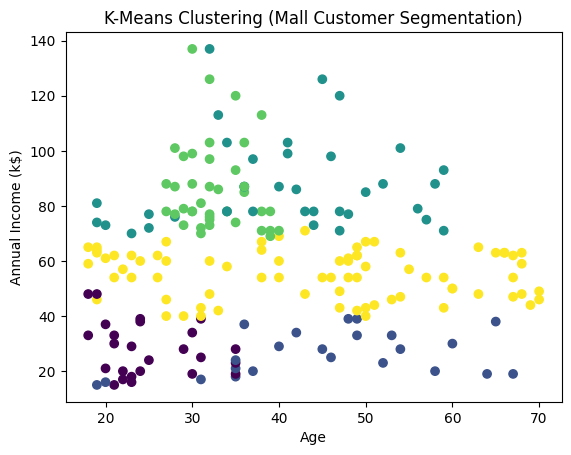

In [14]:
# Plot the clusters
plt.scatter(x, y, c=labels, cmap='viridis')
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
plt.title("K-Means Clustering (Mall Customer Segmentation)")
plt.show()

##### Cluster Profiling to analyze the characteristics of each cluster. 
##### Example we find the mean age, income, and spending score for each cluster, which will give us insights into the customer segments.

In [15]:
cluster_profile = predictions.groupBy("prediction").mean("Age", "Annual Income (k$)", "Spending Score (1-100)")
cluster_profile.show()

+----------+-----------------+-----------------------+---------------------------+
|prediction|         avg(Age)|avg(Annual Income (k$))|avg(Spending Score (1-100))|
+----------+-----------------+-----------------------+---------------------------+
|         1|45.21739130434783|     26.304347826086957|          20.91304347826087|
|         3|32.69230769230769|      86.53846153846153|          82.12820512820512|
|         4|43.93421052631579|      55.21052631578947|          49.44736842105263|
|         2|40.32432432432432|      87.43243243243244|          18.18918918918919|
|         0|            24.96|                  28.04|                       77.0|
+----------+-----------------+-----------------------+---------------------------+



In [17]:
import seaborn as sns

In [19]:
# Perform groupBy operation to calculate the mean of features for each cluster
cluster_profile = predictions.groupBy("prediction").mean("Age", "Annual Income (k$)", "Spending Score (1-100)")

# Show the results in a DataFrame format
cluster_profile.show()

# You can also explicitly cache it if you plan to use it later in the session
cluster_profile.cache()

# If you want to convert it to a Pandas DataFrame (for local use or visualization):
pandas_cluster_profile = cluster_profile.toPandas()
pandas_cluster_profile


+----------+-----------------+-----------------------+---------------------------+
|prediction|         avg(Age)|avg(Annual Income (k$))|avg(Spending Score (1-100))|
+----------+-----------------+-----------------------+---------------------------+
|         1|45.21739130434783|     26.304347826086957|          20.91304347826087|
|         3|32.69230769230769|      86.53846153846153|          82.12820512820512|
|         4|43.93421052631579|      55.21052631578947|          49.44736842105263|
|         2|40.32432432432432|      87.43243243243244|          18.18918918918919|
|         0|            24.96|                  28.04|                       77.0|
+----------+-----------------+-----------------------+---------------------------+



,prediction,avg(Age),avg(Annual Income (k$)),avg(Spending Score (1-100))
0,1,45.217391,26.304348,20.913043
1,3,32.692308,86.538462,82.128205
2,4,43.934211,55.210526,49.447368
3,2,40.324324,87.432432,18.189189
4,0,24.960000,28.040000,77.000000


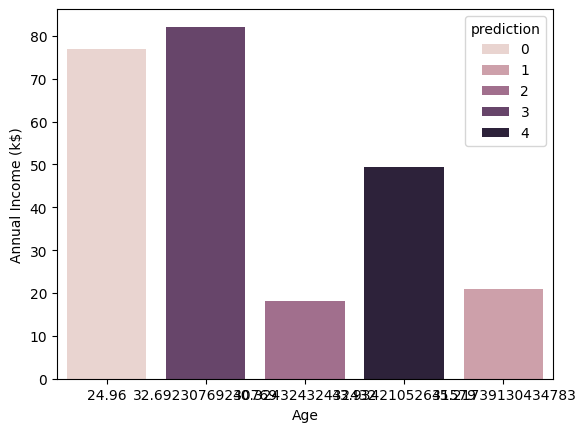

<Figure size 10000x600 with 0 Axes>

In [26]:
sns.barplot(data=pandas_cluster_profile, x="avg(Age)", y="avg(Spending Score (1-100))", hue = "prediction", legend=True)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
plt.figure(figsize=(100, 6))
plt.show()

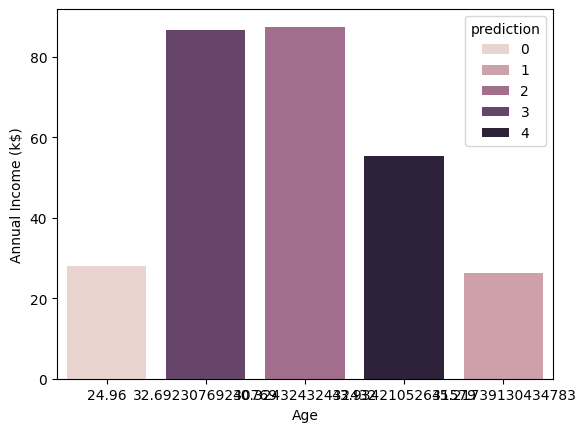

<Figure size 10000x600 with 0 Axes>

In [27]:
sns.barplot(data=pandas_cluster_profile, x="avg(Age)", y="avg(Annual Income (k$))", hue = "prediction", legend=True)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
plt.figure(figsize=(100, 6))
plt.show()